In [7]:
# Setup PySpark and Spark NLP on Colab
!wget https://setup.johnsnowlabs.com/colab.sh -O - | bash
!pip install wordcloud     # wordcloud-1.9.3
!pip install plotly     # plotly-5.15.0

--2024-04-01 14:31:06--  https://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-04-01 14:31:07--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2024-04-01 14:31:07 (41.6 MB/s) - written to stdout [1191/1191]

Installi

In [11]:
from pyspark import SparkConf, SparkContext, SQLContext
import re

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [10]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [12]:
# Configuration
conf = SparkConf()
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [49]:
# Get train and test datasets from yelp_2
# Download from
train_rdd = sc.textFile("drive/MyDrive/train.csv")
test_rdd = sc.textFile("drive/MyDrive/test.csv")

# Convert to rdd
def split(line):
  label = int(line[1])
  sentence = line[5:-1]
  return label, sentence

train_rdd = train_rdd.map(split)
test_rdd = test_rdd.map(split)

# Get the first 10 rows
for row in train_rdd.take(10):
  print(row)      # label, text

(1, "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.")
(2, "Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. 

In [50]:
# Preprocess
nltk.download('stopwords')

# Remove special characters
pattern = r'[^a-zA-Z0-9\s]'     # Define a pattern that only includes whitespaces and alphanumeric characters
def remove_special_characters(text):
    text = re.sub(pattern, ' ', text)     # Replace characters not belonging to the pattern with whitespace
    return text.replace('\n', ' ')      # Replace '\n' with whitespace

# Remove indepedent numbers and stopwords
def is_number(s):
    if s.isdigit():
        return True
    try:
        float(s)
        return True
    except:
        return False
stop_words = set(stopwords.words('english'))
stop_words.add('')
def remove_numbers_and_stopwords(text):
    return " ".join([x for x in text.split(' ') if not is_number(x) and x not in stop_words])

# Remove abundant spaces
def remove_extra_spaces(text):
    return " ".join(text.split(' '))

# Lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

def preprocess(text):
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_numbers_and_stopwords(text)
    text = remove_extra_spaces(text)
    text = lemmatize(text)
    return text

# Remove rows with empty word lists
def filter_empty_and_none(row):
    return row[1] is not None and len(row[1]) > 0

train_preprocessed_rdd = (
    train_rdd
    .map(lambda x : (x[0], preprocess(x[1])))
    .filter(filter_empty_and_none)
)
test_preprocessed_rdd = (
    test_rdd
    .map(lambda x : (x[0], preprocess(x[1])))
    .filter(filter_empty_and_none)
)

for row in test_preprocessed_rdd.take(10):
  print(row)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(2, 'contrary review zero complaint service price getting tire service past year compared experience place like pep boy guy experienced know nalso one place feel like taken advantage gender auto mechanic notorious capitalizing ignorance car sucked bank account dry service road coverage well explained let decide nand renovated waiting room look lot better previous year')
(1, 'last summer appointment get new tire wait super long time also went week fix minor problem tire put fixed free next morning issue called complain manager even apologize frustrated never going back seem overpriced')
(2, 'friendly staff starbucks fair get anywhere else sometimes line get long')
(1, 'food good unfortunately service hit miss main issue seems kitchen waiter waitress often apologetic long wait pretty obvious avoid table taking initial order avoid hearing complaint')
(2, 'even car filene basement worth bus trip waterfront always find something usually find thing spend better still always still wearing clo

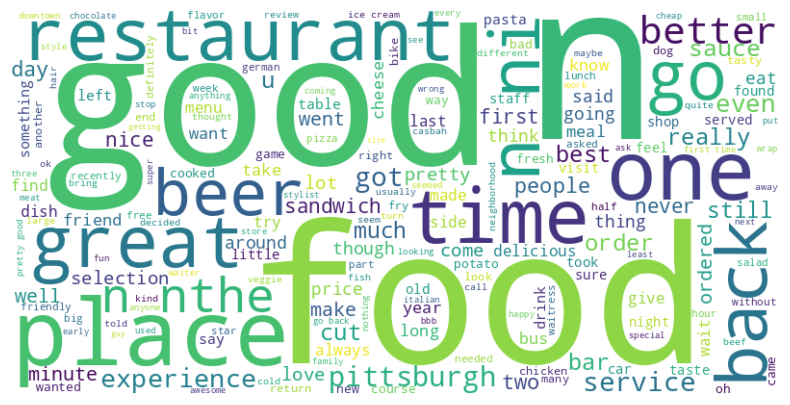

In [58]:
# WordCloud
# Flatten the word lists of a part of the dataset and concatenate them into a single string
words_rdd = test_preprocessed_rdd.map(lambda x: x[1])
words_rdd = sc.parallelize(words_rdd.take(100))
str_rdd = words_rdd.reduce(lambda x, y: x + ' ' + y)

# Create a word cloud from the concatenated text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str_rdd)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [59]:
# Tokenize
train_tokenized_rdd = (
    train_preprocessed_rdd.map(lambda x: (x[0], x[1].split(" ")))
)
test_tokenized_rdd = (
    test_preprocessed_rdd.map(lambda x: (x[0], x[1].split(" ")))
)

# Convert to DataFrame
# label, text
train_df = train_tokenized_rdd.toDF(['label', 'text'])
test_df = test_tokenized_rdd.toDF(['label', 'text'])

test_df.show(10)

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    2|[contrary, review...|
|    1|[last, summer, ap...|
|    2|[friendly, staff,...|
|    1|[food, good, unfo...|
|    2|[even, car, filen...|
|    2|[picture, billy, ...|
|    1|[mediocre, servic...|
|    1|[ok, let, tell, b...|
|    1|[used, love, b, f...|
|    2|[like, barnes, no...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
# Word2Vec
from pyspark.ml.feature import Word2Vec

# Fit the Word2Vec model
word2vec = Word2Vec(vectorSize=200, seed=42, inputCol="text", outputCol="word2vec")
word2vec.setMaxIter(10)
word2vec_model = word2vec.fit(train_df)

# Transformation
word2vec_train_df = word2vec_model.transform(train_df).drop("text")
word2vec_test_df = word2vec_model.transform(test_df).drop("text")

word2vec_test_df.select("word2vec").show(10, truncate=False)

In [ ]:
# BOW(CountVectorizer)
from pyspark.ml.feature import CountVectorizer

# Fit the Word2Vec model
bow = CountVectorizer(inputCol="text", outputCol="bow")
bow_model = bow.fit(train_df)

# Transformation
bow_train_df = bow_model.transform(train_df).drop("text")
bow_test_df = bow_model.transform(test_df).drop("text")

bow_test_df.select("bow").show(10, truncate=False)

In [ ]:
# tf-idf
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Apply HashingTF to get term frequency vectors
hashingTF = HashingTF(inputCol="text", outputCol="tf", numFeatures=200)
tf_train_df = hashingTF.transform(train_df).drop("text")
tf_test_df = hashingTF.transform(test_df).drop("text")

# Apply IDF to the term frequency vectors
idf = IDF(inputCol="tf", outputCol="idf")
idf_model = idf.fit(tf_train_df)
idf_train_df = idf_model.transform(tf_train_df)
idf_test_df = idf_model.transform(tf_test_df)

# Compute TF-IDF using the two columns
idf_train_rdd = idf_train_df.rdd
idf_test_rdd = idf_test_df.rdd

def compute_tf_idf(tf, idf):
  return (tf.toArray() * idf.toArray()).tolist()

tfidf_train_rdd = idf_train_rdd.map(
   lambda x: (x[0], compute_tf_idf(x[1], x[2]))
)
tfidf_test_rdd = idf_test_rdd.map(
   lambda x: (x[0], compute_tf_idf(x[1], x[2]))
)

for row in tfidf_test_rdd.take(1):
  print(row[1])